In [2]:
import torch
from torchvision.models import resnet18
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
model = resnet18(num_classes=2)
model.load_state_dict(torch.load('/content/drive/MyDrive/resnet.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
value_to_prob = nn.Softmax(dim=1).to(device)

In [69]:
# Function to perform sliding window
def sliding_window(image, stepSize, windowSize):
    # Slide a window across the image
    for y in range(0, image.shape[0] - windowSize[1], stepSize):
        for x in range(0, image.shape[1] - windowSize[0], stepSize):
            # Yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

# Function to detect faces using sliding window
def detect_faces(image, model, window_size, stride, threshold):
    detections = []
    for (x, y, window) in sliding_window(image, stride, window_size):

        # Convert window to PyTorch tensor
        window_tensor = torch.from_numpy(window.transpose(2, 0, 1)).float().unsqueeze(0)

        # Perform inference
        with torch.no_grad():
            outputs = model(window_tensor)

        # Check if face is detected
        proba = np.argmax(value_to_prob(outputs),axis=1)
        if proba > threshold:
            detections.append((x, y, proba))

    return detections

# Function to merge overlapping bounding boxes
def merge_bounding_boxes(detections, overlap_threshold, window_size):
    merged_boxes = []

    while len(detections) > 0:
        # Get the first detection and remove it from the list
        detection = detections.pop(0)
        x1, y1, proba = detection

        # Create a list to store overlapping detections
        overlapping_detections = [detection]

        for next_detection in detections[:]:
            x2, y2, _ = next_detection

            # Calculate overlap
            overlap = max(0, min(x1 + window_size[0], x2 + window_size[0]) - max(x1, x2)) * \
                      max(0, min(y1 + window_size[1], y2 + window_size[1]) - max(y1, y2))

            # Calculate area of both bounding boxes
            area1 = window_size[0] * window_size[1]
            area2 = window_size[0] * window_size[1]

            # Calculate IOU (Intersection over Union)
            iou = overlap / float(area1 + area2 - overlap)

            if iou > overlap_threshold:
                # If overlapping, merge boxes and remove the overlapping detection from the list
                detections.remove(next_detection)
                overlapping_detections.append(next_detection)

        # Calculate average position and probability of the merged detection
        avg_x = int(np.mean([det[0] for det in overlapping_detections]))
        avg_y = int(np.mean([det[1] for det in overlapping_detections]))
        avg_proba = np.mean([det[2] for det in overlapping_detections])

        merged_boxes.append((avg_x, avg_y, avg_proba))

    return merged_boxes

def face_detect(image_path):
  # Load image
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Set parameters
  window_size = (64, 64)  # Window size for sliding window
  stride = 10  # Stride for sliding window
  threshold = 0.5  # Threshold for face detection
  overlap_threshold = 0.1  # Threshold for merging overlapping bounding boxes

  # Detect faces
  detections = detect_faces(image, model, window_size, stride, threshold)

  # Merge overlapping bounding boxes
  merged_boxes = merge_bounding_boxes(detections, overlap_threshold, window_size)

  # Draw bounding boxes on image
  for (x, y, proba) in merged_boxes:
      if proba > threshold:
          cv2.rectangle(image, (x, y), (x + window_size[0], y + window_size[1]), (0, 255, 0), 2)

  # Display result
  cv2_imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
  cv2.waitKey(0)
  cv2.destroyAllWindows()

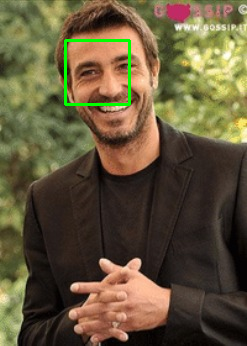

In [70]:
face_detect('pic1.jpg')